In [14]:
#import các thư viện
import pandas as pd
import numpy as np
%matplotlib inline 
#to plot the whatever graphic
import matplotlib.pyplot as plt #plot data
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

In [15]:
#import data STB
df_STB = pd.read_csv('../STB-Historical-Data.csv')
df_STB = df_STB[['Date','Price']]
df_STB

,Date,Price
0,1/2/2019,"11,600.00"
1,1/3/2019,"11,100.00"
2,1/4/2019,"11,150.00"
3,1/7/2019,"11,500.00"
4,1/8/2019,"11,350.00"
...,...,...
1107,6/12/2023,"28,200.00"
1108,6/13/2023,"28,200.00"
1109,6/14/2023,"27,800.00"
1110,6/15/2023,"27,800.00"


In [16]:
#import data VNI
df_VNI=pd.read_csv('../VN-Index-Historical-Data.csv')
df_VNI= df_VNI[['Date','Price']]
df_VNI

,Date,Price
0,1/2/2019,891.75
1,1/3/2019,878.22
2,1/4/2019,880.9
3,1/7/2019,889.64
4,1/8/2019,887.44
...,...,...
1107,6/12/2023,"1,116.02"
1108,6/13/2023,"1,122.46"
1109,6/14/2023,"1,117.42"
1110,6/15/2023,"1,116.97"


In [17]:
#Chuyển dữ liệu lần cuối, % thay đổi về dạng int
df_STB['Price']=df_STB['Price'].replace(',','',regex=True).astype(float)
df_VNI['Price']=df_VNI['Price'].replace(',','',regex=True).astype(float)

In [18]:
df = pd.merge(df_STB, df_VNI, on='Date')
df.head()

,Date,Price_x,Price_y
0,1/2/2019,11600.0,891.75
1,1/3/2019,11100.0,878.22
2,1/4/2019,11150.0,880.90
3,1/7/2019,11500.0,889.64
4,1/8/2019,11350.0,887.44


In [19]:
name_mapping = {'Price_x':'Price_STB','Price_y':'Price_VNI'}

In [20]:
df = df.rename(columns=name_mapping)
df

,Date,Price_STB,Price_VNI
0,1/2/2019,11600.0,891.75
1,1/3/2019,11100.0,878.22
2,1/4/2019,11150.0,880.90
3,1/7/2019,11500.0,889.64
4,1/8/2019,11350.0,887.44
...,...,...,...
1107,6/12/2023,28200.0,1116.02
1108,6/13/2023,28200.0,1122.46
1109,6/14/2023,27800.0,1117.42
1110,6/15/2023,27800.0,1116.97


In [21]:
# data = data.reset_index(drop=True) # Reset the index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df[['Price_STB', 'Price_VNI']]
df = df.dropna() # Drop missing values

# Split the df into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]
print(len(train_data))
print(len(test_data))
print(len(val_data))

778
222
112


In [22]:
train_exog = train_data[["Price_VNI"]]
model = auto_arima(train_data['Price_STB'], 
                      test='adf',       # use adftest to find      
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True,  
                      stepwise=True,
                      exogenous= train_exog)
print(model.summary())

Performing stepwise search to minimize aic


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=11803.429, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11798.433, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11797.462, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11797.455, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11799.124, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=11799.454, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=11799.475, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=11801.460, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=11798.526, Time=0.03 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.947 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  778
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -5895.727
Date:                Sat, 17 Jun 2023   AIC                          11797.455
Time

In [23]:
model= SARIMAX(train_data['Price_STB'], 
 exog=train_exog,
 order=(0,1,1),
 enforce_invertibility=False, enforce_stationarity=False)

In [24]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price_STB'])
test_exog = test_data[['Price_VNI']]
model_fit = model.fit()
# y_pred = model.predict(n_periods=len(y_test))
y_pred = model_fit.forecast(steps=len(y_test), exog=test_exog)
print(y_pred)

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price_STB'])
val_exog = val_data[['Price_VNI']]
print(val_exog)
y_pred_val =  model_fit.forecast(steps=len(y_val), exog=val_exog)
print(y_pred_val)

778    33480.946077
779    33851.251599
780    33777.843015
781    33917.668889
782    33745.916108
           ...     
995    22486.903703
996    21668.223211
997    22119.394698
998    22377.839521
999    22229.391052
Name: predicted_mean, Length: 222, dtype: float64
            Price_VNI
Date                 
2022-12-30    1007.09
2023-01-03    1043.90
2023-01-04    1046.35
2023-01-05    1055.82
2023-01-06    1051.44
...               ...
2023-06-12    1116.02
2023-06-13    1122.46
2023-06-14    1117.42
2023-06-15    1116.97
2023-06-16    1115.22

[112 rows x 1 columns]
778    22178.121565
779    23035.953301
780    23093.048866
781    23313.740703
782    23211.667815
           ...     
885    24716.660304
886    24866.740075
887    24749.286341
888    24738.799401
889    24698.016854
Name: predicted_mean, Length: 112, dtype: float64


In [25]:
# Tính độ đo MDA trên tập test
y_test_actual = np.array(test_data['Price_STB'])
y_test_predicted = y_pred
test_correct = np.where(np.sign(np.diff(y_test_actual)) == np.sign(np.diff(y_test_predicted)), 1, 0)
test_mda = np.mean(test_correct)
# Tính độ đo MDA trên tập validation
y_val_actual = np.array(val_data['Price_STB'])
y_val_predicted = y_pred_val
val_correct = np.where(np.sign(np.diff(y_val_actual)) == np.sign(np.diff(y_val_predicted)), 1, 0)
val_mda = np.mean(val_correct)

Validation RMSE: 2562.14
Testing RMSE: 4207.05
Validation MAPE: 8.99%
Testing MAPE: 17.50%
Testing MDA: 71.04%
Validation MDA: 68.47%


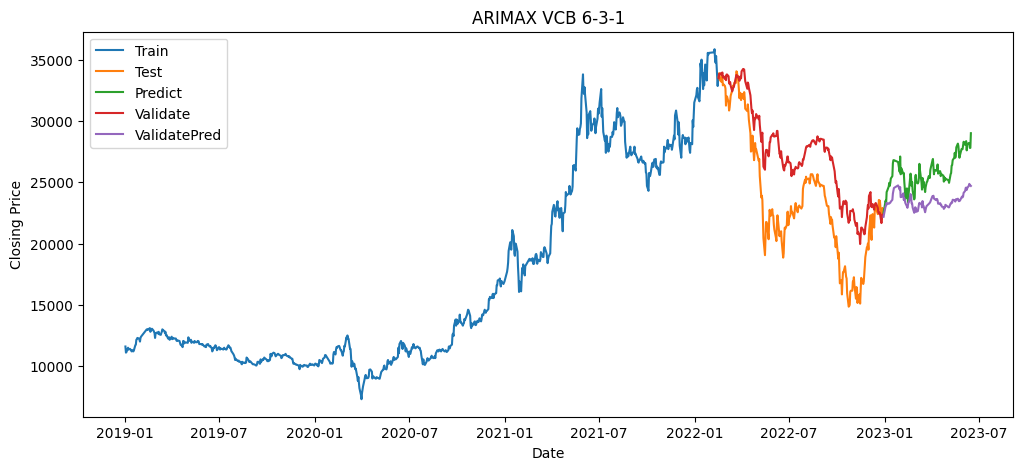

In [26]:
# 8. Tính các độ đo
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
valid_mape = np.mean(np.abs(y_pred_val - y_val)/np.abs(y_val))  # MAPE
test_mape = np.mean(np.abs(y_pred - y_test)/np.abs(y_test))  # MAPE
valid_mae = mean_absolute_error(y_pred_val,y_val) # MAE
test_mae = mean_absolute_error(y_pred,y_test)
print(f"Validation RMSE: {valid_rmse:.2f}")
print(f"Testing RMSE: {test_rmse:.2f}")
print(f"Validation MAPE: {valid_mape* 100:.2f}%")
print(f"Testing MAPE: {test_mape*100:.2f}%")
print(f"Testing MDA: {test_mda*100:.2f}%")
print(f"Validation MDA: {val_mda*100:.2f}%")
# 9.Vẽ hình
plt.figure(figsize=(12,5), dpi=100)
plt.ylabel('Closing Price');
plt.xlabel('Date');
plt.title('ARIMAX VCB 6-3-1')
plt.plot(train_data.index, train_data['Price_STB'])
plt.plot(test_data.index, test_data['Price_STB'])
plt.plot(val_data.index, val_data['Price_STB'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
# plt.plot(last_data,y_next_30_days)
#plt.plot(next_30_days_index,y_next_30_days)
#plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.legend(['Train', 'Test', 'Predict','Validate','ValidatePred'])
plt.show()